# Basic characterizations of UA Q4
### using Experiment and Analysis classes

In [1]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qm.octave import QmOctaveConfig
from quam import QuAM

from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
#from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber
import xarray as xr

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 0 # for UA Q4
TLS_index = 0 # for TLS of interest
dc_flux_index = 3 # for dc line

2024-09-17 09:28:49,759 - qm - INFO     - Starting session: a428ee5d-d3c8-4903-94ea-9a6966832ac2


In [2]:
Analysis = AnalysisHandle("quam_state_q3.json")
machine = Analysis.get_machine()
Experiment = ExperimentHandle(machine)

In [3]:
# Set voltage of flux line to 0 V
for i in np.arange(7):
    machine.dc_flux[i].dc_voltage = 0 + 0E6
machine = Analysis.set_machine(machine)

In [4]:
# initialize Labber-controlled hardware
# get values from QDAC first
#machine = Experiment.set_Labber.get_value_from_QDAC(machine)
# set all Labber settings
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
# set octave to external clock
#Experiment.set_octave.set_clock(machine)

In [5]:
# set to qubit
machine.octaves[0].LO_sources[1].LO_frequency = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)

In [6]:
machine.octaves[0].LO_sources[1].gain = 0
machine = Analysis.set_machine(machine)

In [8]:
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q3 for (LO, IF) = (5.955 GHz, -50.000 MHz)
------------------------------------- Calibrates r3 for (LO, IF) = (6.930 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


# Qubit Readout

## Time of Flight

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 52.93s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0917\2024-09-17_q3_time_of_flight_2
DC offset to add to I: -0.000094 V
DC offset to add to Q: 0.000358 V
TOF to add: 0.0 ns


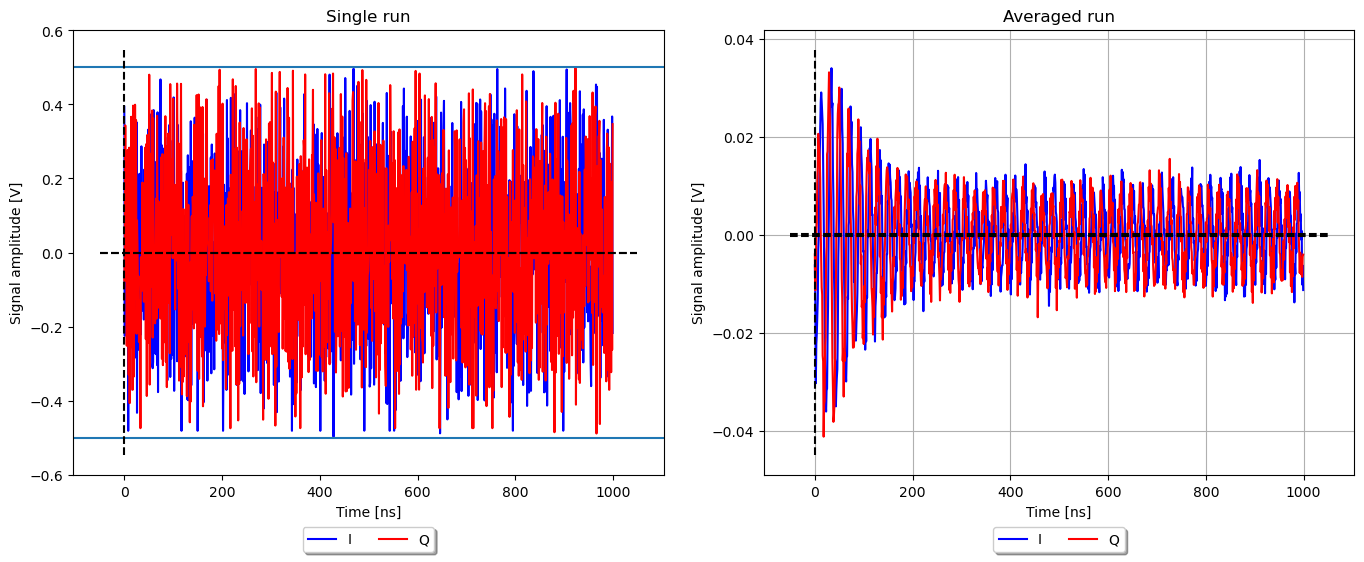

In [11]:
# time_of_flight
# experiment
%matplotlib qt
machine, expt_dataset = Experiment.exp1D.RR.time_of_flight(machine,qubit_index, n_avg = 10E3, cd_time = 10E3, to_simulate = False, simulation_len = 1000)
# plot
%matplotlib inline
dc_offset_i, dc_offset_q, delay = Analysis.exp1D.time_of_flight(expt_dataset)

In [12]:
# update the offset
machine.global_parameters.downconversion_offset_I[0] += dc_offset_i
machine.global_parameters.downconversion_offset_Q[0] += dc_offset_q
machine.resonators[qubit_index].downconversion_offset_I = machine.global_parameters.downconversion_offset_I[0]
machine.resonators[qubit_index].downconversion_offset_Q = machine.global_parameters.downconversion_offset_Q[0]
machine.resonators[0].time_of_flight = 304 
machine = Analysis.set_machine(machine)

In [532]:
machine.global_parameters.downconversion_gain[0] = -1
machine.resonators[qubit_index].downconversion_gain = -1
machine = Analysis.set_machine(machine)

## Resonator spectroscopy

### 1D resonator spectroscopy

In [23]:
%matplotlib qt
res_freq_sweep = machine.resonators[qubit_index].f_readout + np.arange(-10E6,10E6 + 1.0,0.05E6)
machine, expt_dataset = Experiment.exp1D.RR.rr_freq(machine, res_freq_sweep, qubit_index, n_avg = 2E3, cd_time = 10E3, live_plot = True,
                                                    readout_state = 'g', to_simulate = False, data_process_method = 'Amplitude')
# Readout in excited state
# machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
#                           n_avg = 1E3, cd_time = 5E3, readout_state = 'e', simulate_flag = False, simulation_len = 1000)

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 9.00s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0917\2024-09-17_q3_res_spec_3
Execution stopped by user!


resonator frequency: 6880.000 MHz


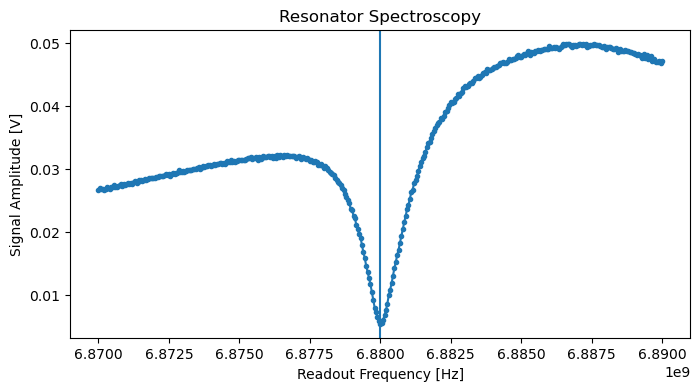

In [24]:
# find the minimal
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(expt_dataset)
machine.resonators[qubit_index].f_readout = res_freq + 0E6

In [25]:
machine.octaves[0].LO_sources[0].LO_frequency = machine.resonators[qubit_index].f_readout + 50E6
machine = Experiment.set_octave.calibration(machine, qubit_index)
machine = Analysis.set_machine(machine)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q3 for (LO, IF) = (5.955 GHz, -50.000 MHz)
------------------------------------- Calibrates r3 for (LO, IF) = (6.930 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


In [15]:
# set DC voltage to sweet spot, after possible dc flux sweep
machine.dc_flux[dc_flux_index].dc_voltage = machine.dc_flux[dc_flux_index].max_frequency_point 
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
machine = Analysis.set_machine(machine)

### 2D resonator spectroscopy

In [17]:
res_freq_sweep = machine.resonators[0].f_readout + np.arange(-7e6, 3e6, 0.1E6)
dc_flux_sweep = np.arange(-9,9.001,0.1)
%matplotlib qt
machine, expt_dataset = Experiment.exp2D.RR.rr_vs_dc_flux(machine, res_freq_sweep, dc_flux_sweep, qubit_index,
                                                          n_avg = 1000, cd_time = 10E3, live_plot = True)

Progress: [##################################################] 100.0% (n=181/181) --> elapsed time: 363.71s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0917\2024-09-17_q3_res_spec2D


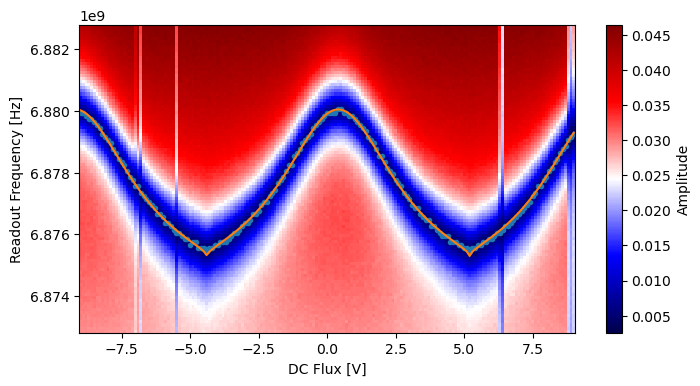

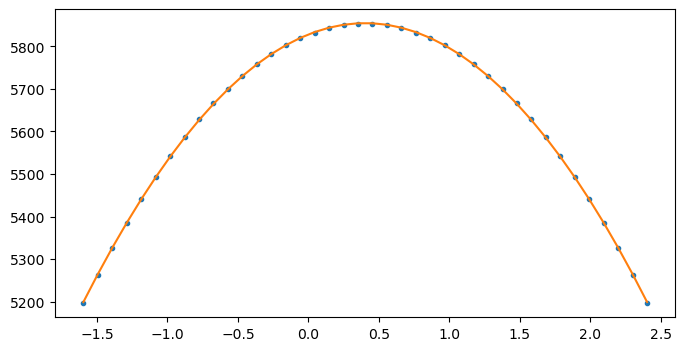

In [19]:
%matplotlib inline
ham_param = Analysis.exp2D.rr_vs_dc_flux(expt_dataset, to_plot =True, init_guess = [6950, 190, 32E3, 0.05, 0.3, 74])
poly_param = Analysis.exp2D.qubit_vs_dc_flux_guess(ham_param = ham_param, to_plot = True)

In [20]:
# save the fitting parameters
machine.resonators[qubit_index].tuning_curve = ham_param
machine.qubits[qubit_index].DC_tuning_curve = poly_param
machine = Analysis.set_machine(machine)

In [21]:
# save the sweep spot flux according to fitted parameter
machine.dc_flux[dc_flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param)
machine = Analysis.set_machine(machine)

if 2D res spectroscopy is just to test the experiment, and I want to go back to sweet spot

In [22]:
machine = Analysis.update_machine_res_frequency_sweet_spot(machine, qubit_index, dc_flux_index) 
machine.octaves[0].LO_sources[0].LO_frequency = machine.resonators[qubit_index].f_readout + 50e6
machine.dc_flux[dc_flux_index].dc_voltage = machine.dc_flux[dc_flux_index].max_frequency_point
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
machine = Analysis.set_machine(machine)
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q3 for (LO, IF) = (5.955 GHz, -50.000 MHz)
------------------------------------- Calibrates r3 for (LO, IF) = (6.930 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


# Qubit Sweet Spot Calibrations

## 1D qubit spectroscopy @ sweep spot

### Qubit spectroscopy as a function of time

In [540]:
qubit_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,0.0) * 1E6 # in Hz
qubit_freq_sweep = int(qubit_freq_est) + np.arange(-25E6, 10E6 + 1, 0.1E6)

for n in np.arange(200):
    machine, expt_dataset = Experiment.exp2D.Rabi.qubit_freq_time(machine, qubit_freq_sweep, qubit_index, N_rounds = 100, pi_amp_rel = 1.0, ff_amp = 0.0, n_avg = 1E4, cd_time = 20E3, to_simulate = False, simulation_len = 3000, final_plot=True, live_plot=False, data_process_method = 'I')
		

Progress: [##################################################] 100.0% (n=100/100) --> elapsed time: 8310.78s
----------saved to Z:\QM_Data_DF5\2024\07\Data_0730\2024-07-30_q3_time_spec
Progress: [##################################################] 100.0% (n=100/100) --> elapsed time: 8309.30s
----------saved to Z:\QM_Data_DF5\2024\07\Data_0730\2024-07-30_q3_time_spec_2
Progress: [##################################################] 100.0% (n=100/100) --> elapsed time: 8307.14s
----------saved to Z:\QM_Data_DF5\2024\07\Data_0730\2024-07-30_q3_time_spec_3
Progress: [##################################################] 100.0% (n=100/100) --> elapsed time: 8310.21s
----------saved to Z:\QM_Data_DF5\2024\07\Data_0731\2024-07-31_q3_time_spec
Progress: [##################################################] 100.0% (n=100/100) --> elapsed time: 8308.68s
----------saved to Z:\QM_Data_DF5\2024\07\Data_0731\2024-07-31_q3_time_spec_2
Progress: [##################################################] 100.0%

GRPCError: (<Status.INTERNAL: 13>, "unknown error while fetching results for job '1720559042456'", None)

Execution stopped by user!


In [124]:
machine.octaves[0].LO_sources[1].LO_frequency =5904827545.0 + 50e6
machine.qubits[qubit_index].f_01  = 5904827545.0 + 0e6
machine = Experiment.set_octave.calibration(machine, qubit_index)
machine = Analysis.set_machine(machine)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q3 for (LO, IF) = (5.955 GHz, -50.000 MHz)
------------------------------------- Calibrates r3 for (LO, IF) = (6.930 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


In [65]:
if True: # for the DC flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].DC_tuning_curve,machine.dc_flux[dc_flux_index].max_frequency_point) * 1E6 # in Hz
else: # for the fast flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,0.0) * 1E6 # in Hz

qubit_freq_sweep = int(qubit_freq_est) + np.arange(25E6, 75E6 + 1, 0.5E6)
# qubit_freq_sweep = int(5459245860) + np.arange(-150E6, 150E6 + 1, 1E6)

    
%matplotlib qt
machine, expt_dataset = Experiment.exp1D.Rabi.qubit_freq(machine, qubit_freq_sweep, qubit_index, pi_amp_rel = 1.0, live_plot = True,
                                                         ff_amp = 0, n_avg = 1E4, cd_time = 30E3, to_simulate = False, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 31.63s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 32.19s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0917\2024-09-17_q3_spec_8
Execution stopped by user!


peak frequency:  5904.7 [MHz]


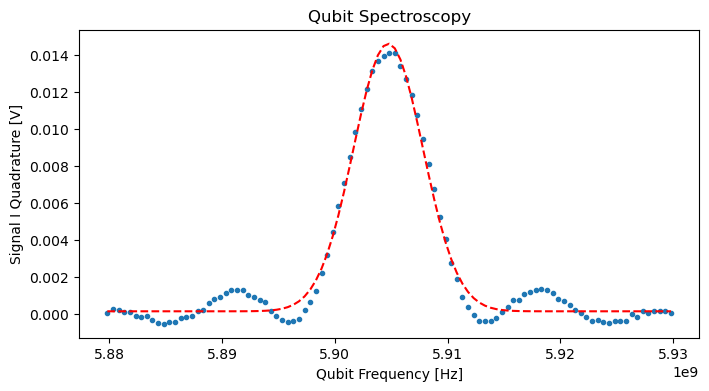

In [66]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(expt_dataset, method="Gaussian", data_process_method = 'I')
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
# machine.qubits[qubit_index].f_01 = 5904.0E6 +0E6
machine = Analysis.set_machine(machine)

In [67]:
machine.octaves[0].LO_sources[1].LO_frequency = machine.qubits[qubit_index].f_01 + 50e6
machine = Experiment.set_octave.calibration(machine, qubit_index)
machine = Analysis.set_machine(machine)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q3 for (LO, IF) = (5.955 GHz, -50.000 MHz)
------------------------------------- Calibrates r3 for (LO, IF) = (6.930 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


## Rabi

### Time Rabi

In [60]:
%matplotlib qt
rabi_duration_sweep = np.arange(24, 250 + 0.1, 4)  # in ns
machine, expt_dataset = Experiment.exp1D.Rabi.rabi_length(machine, rabi_duration_sweep, qubit_index, pi_amp_rel = 1, live_plot = True, 
                                                          ff_amp = 0, n_avg = 5E4, cd_time = 25E3, to_simulate = False, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 76.79s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0917\2024-09-17_q3_time_rabi_13
Execution stopped by user!


rabi_pi_pulse: 99.8 [ns]
pi period: 99.08 [ns]
T2rabi: 38946333818.6 [ns]


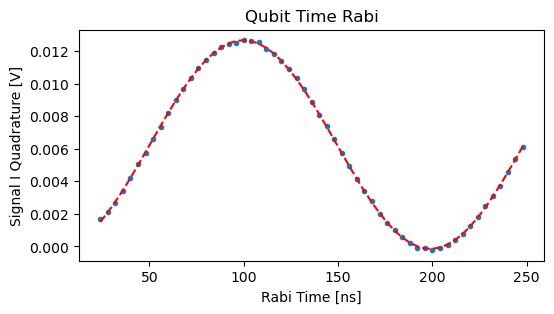

In [62]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(expt_dataset, method = "Decay", to_plot = True, data_process_method = 'I')

In [47]:
machine.qubits[qubit_index].pi_length = 100
machine.qubits[qubit_index].pi_amp =0.1
machine = Analysis.set_machine(machine)

In [52]:
machine.qubits[qubit_index].pi_amp = 0.018
machine = Analysis.set_machine(machine)

### Power Rabi

In [56]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.1, 2, 0.03) 
machine, expt_dataset = Experiment.exp1D.Rabi.rabi_amp(machine, rabi_amp_sweep_rel, qubit_index, ff_amp = 0, live_plot = True,
                                       n_avg = 10E3, cd_time = 25E3, data_process_method = 'I')

Execution stopped by user!###                                ] 36.6% (n=3665/10000.0) --> elapsed time: 6.09s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 17.21s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0917\2024-09-17_q3_power_rabi_6
Execution stopped by user!


rabi_pi_amp: 0.019 [V]
pi period: 0.019 [V]


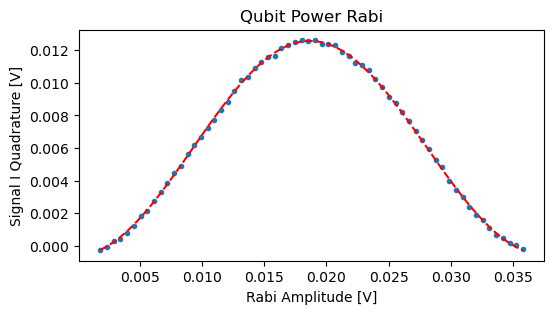

In [58]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(expt_dataset, method = "Decay", data_process_method = 'I')
machine.qubits[qubit_index].pi_amp = pi_pulse_amp
machine = Analysis.set_machine(machine)

## Single-Shot Readout

### Find frequency between g, e

In [70]:
%matplotlib qt
res_freq_sweep = machine.resonators[qubit_index].f_readout + np.arange(-2.5E6,1E6 + 1.0,0.05E6)
machine, expt_dataset = Experiment.exp1D.RR.rr_freq_ge(machine, res_freq_sweep, qubit_index, n_avg = 1E4, cd_time = 10E3,
                                                    to_simulate = False, simulation_len = 1000, live_plot = True, data_process_method = 'Phase')

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 15.90s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0917\2024-09-17_q3_res_spec_ge_3
Execution stopped by user!


resonator frequency: 6879.500 MHz


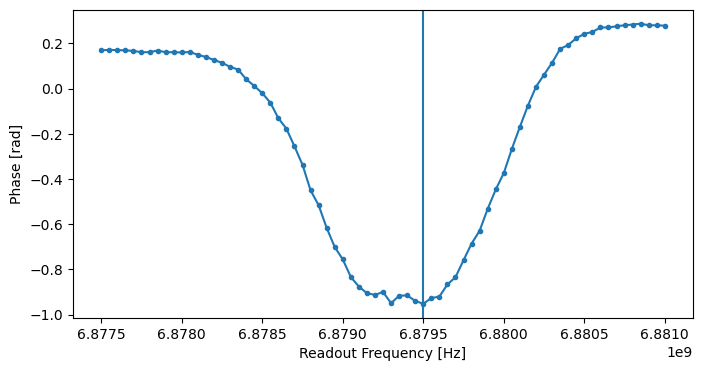

In [71]:
%matplotlib inline
res_freq_phase = Analysis.exp1D.rr_freq_ge(expt_dataset)

In [72]:
# doesn't have to update. Use res_freq_phase
machine.resonators[qubit_index].f_readout = res_freq_phase + 0E6
machine.octaves[0].LO_sources[0].LO_frequency = machine.resonators[qubit_index].f_readout + 50E6
machine = Experiment.set_octave.calibration(machine, qubit_index)
machine = Analysis.set_machine(machine)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q3 for (LO, IF) = (5.955 GHz, -50.000 MHz)
------------------------------------- Calibrates r3 for (LO, IF) = (6.929 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


### IQ blobs

In [101]:
machine, expt_dataset = Experiment.exp1D.RR.single_shot_IQ_blob(machine, qubit_index, n_avg = 30E3, cd_time = 25E3, final_plot = False)

----------saved to Z:\QM_Data_DF5\2024\09\Data_0917\2024-09-17_q3_single_shot_IQ_10-> elapsed time: 1.56s



			Fidelity Matrix:
			-----------------
			| 0.716 | 0.284 |
			----------------
			| 0.301 | 0.699 |
			-----------------
			IQ plane rotated by: 6.3°
			Threshold: 2.999e-03
			Fidelity: 70.7%
			


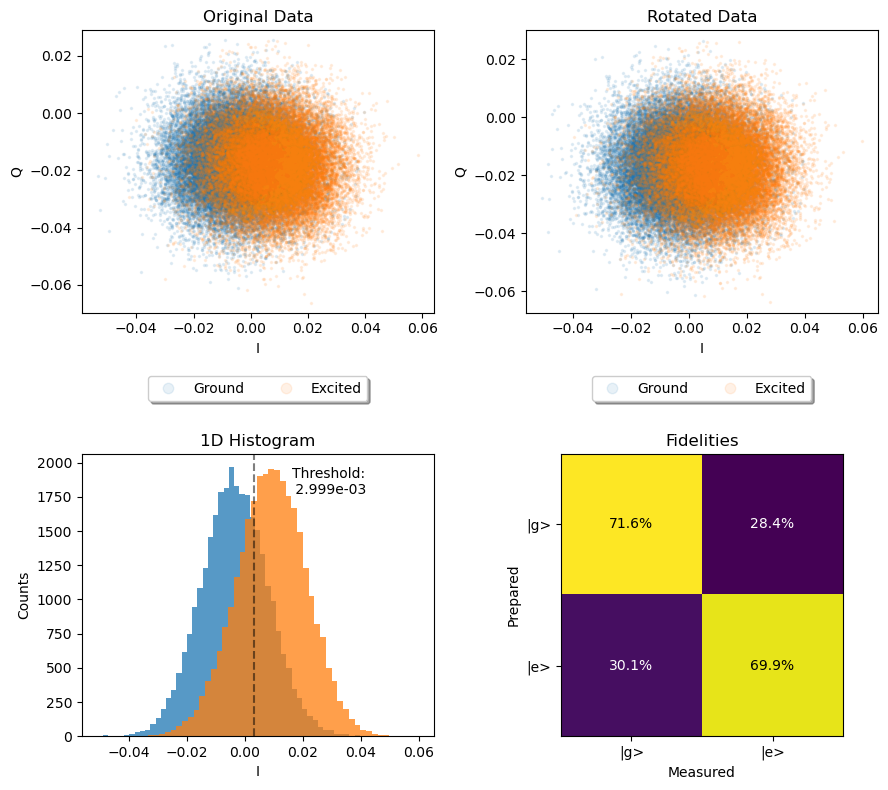

In [102]:
angle, threshold, fidelity, gg, ge, eg, ee = Analysis.exp1D.two_state_discriminator(expt_dataset)

In [75]:
# set the rotation angle
machine.resonators[qubit_index].rotation_angle -= angle # note this is the change value not the absolute value!
machine.resonators[qubit_index].ge_threshold = threshold
machine = Analysis.set_machine(machine)

In [100]:
machine.resonators[qubit_index].readout_pulse_amp = 0.41
machine.resonators[qubit_index].readout_pulse_length = 300
machine = Analysis.set_machine(machine)

### Readout freq optimization

In [237]:
res_freq_sweep = machine.resonators[qubit_index].f_readout + np.arange(-1.5E6, 1.5E6 + 1, 0.05E6)

%matplotlib qt
machine, expt_dataset = Experiment.exp1D.RR.single_shot_freq_optimization(machine, res_freq_sweep, qubit_index, n_avg = 5E4, cd_time = 25E3, 
                                                           final_plot = True, live_plot = True)

Execution stopped by user!                                   ] 6.2% (n=3090/50000.0) --> elapsed time: 9.90s
----------saved to Z:\QM_Data_DF5\2024\07\Data_0712\2024-07-12_q3_single_shot_freq0) --> elapsed time: 10.14s
The optimal readout frequency is 6879199633.0 Hz (SNR=0.34008799692354935)


peak frequency:  6879.3 [MHz]


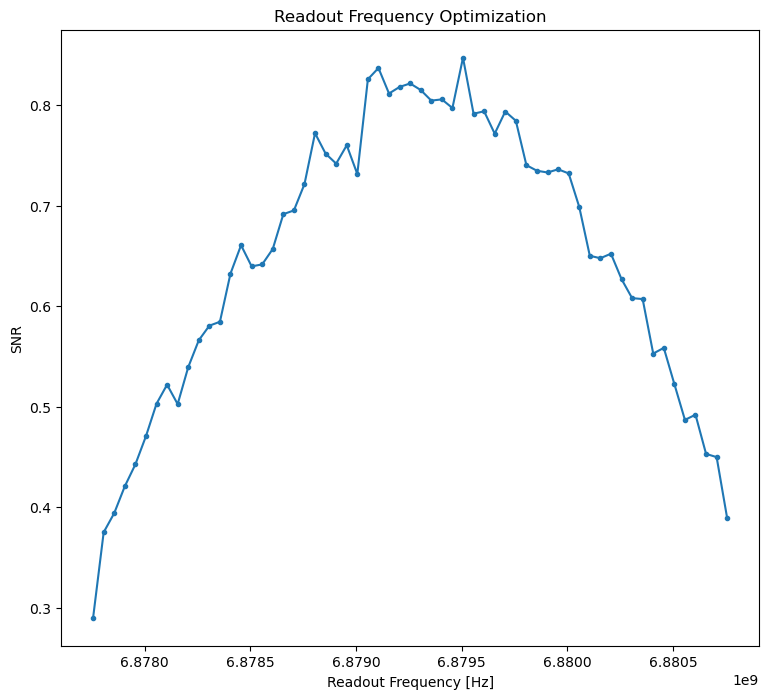

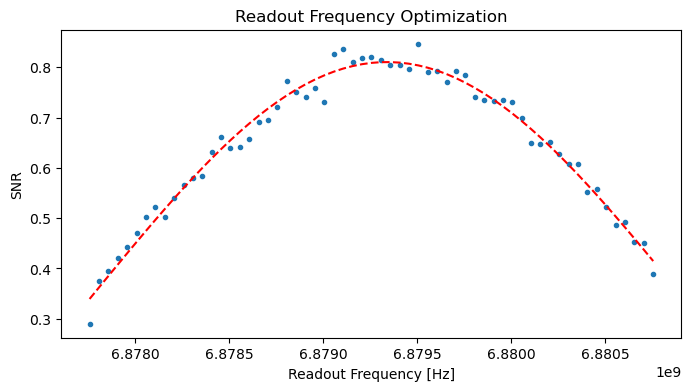

Execution stopped by user!


In [46]:
%matplotlib inline
res_freq = Analysis.exp1D.peak_fit(expt_dataset,method="Gaussian", data_process_method = 'SNR')

In [47]:
machine.resonators[qubit_index].f_readout = res_freq + 0E6
machine.octaves[0].LO_sources[0].LO_frequency = machine.resonators[qubit_index].f_readout + 50E6
machine = Analysis.set_machine(machine)
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q3 for (LO, IF) = (5.938 GHz, -50.000 MHz)
------------------------------------- Calibrates r3 for (LO, IF) = (6.929 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


### Readout pulse amp and duration (by qubit relaxation during readout)

In [121]:
%matplotlib qt
res_duration_sweep_abs = np.arange(300, 2000 + 1, 60)
res_amp_sweep_abs = np.arange(0.15,0.45,0.002)
machine, expt_dataset = Experiment.exp2D.RR.rr_pulse_optimize(machine, res_duration_sweep_abs, res_amp_sweep_abs, qubit_index, n_avg=1E3, 
                                                              cd_time=25E3, live_plot = True, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 124.19s
----------saved to Z:\QM_Data_DF5\2024\07\Data_0709\2024-07-09_q3_res_pulse_optimize
Execution stopped by user!


In [ ]:
machine.resonators[qubit_index].readout_pulse_amp = 0.45
machine.resonators[qubit_index].readout_pulse_length = 600
machine = Analysis.set_machine(machine)

### Readout duration optimization

In [67]:
division_length = 40
%matplotlib qt
machine, expt_dataset = Experiment.exp1D.RR.single_shot_duration_optimization(machine, division_length, qubit_index,
                                                                    readout_len = 2000, n_avg = 2E4, cd_time = 25E3)

Integration weights chunk-size length in ns: 40
The readout has been sliced in the following number of divisions 50
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.74s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.75s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.77s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.78s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.80s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.81s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.83s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed 

In [68]:
machine.resonators[qubit_index].readout_pulse_length = 1320
machine = Analysis.set_machine(machine)

### Readout amp optimization

In [ ]:
res_amp_sweep = np.arange(0.5,1.5 + 1E-4, 0.01)

%matplotlib qt
machine, expt_dataset = Experiment.exp1D.RR.single_shot_amp_optimization(machine, res_amp_sweep, qubit_index,
                              n_avg = 5E3, cd_time = 25E3, final_plot= True)

In [ ]:
%matplotlib inline
readout_amp = Analysis.exp1D.peak_fit(expt_dataset, method="Gaussian", data_process_method = 'Fidelity')

In [ ]:
machine.resonators[qubit_index].readout_pulse_amp = 0.48
machine = Analysis.set_machine(machine)

## Qubit T1

In [57]:
%matplotlib qt
tau_sweep_abs = np.arange(100,40E3+1,1E3)
machine, expt_dataset = Experiment.exp1D.T1.qubit_T1(machine, tau_sweep_abs, qubit_index, n_avg = 4E3, cd_time = 40E3, live_plot = True,
                                                               to_simulate = False, simulation_len = 15_000, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 9.90s
----------saved to Z:\QM_Data_DF5\2024\08\Data_0822\2024-08-22_q3_T1
Execution stopped by user!


Qubit T1: 5.5 [us]


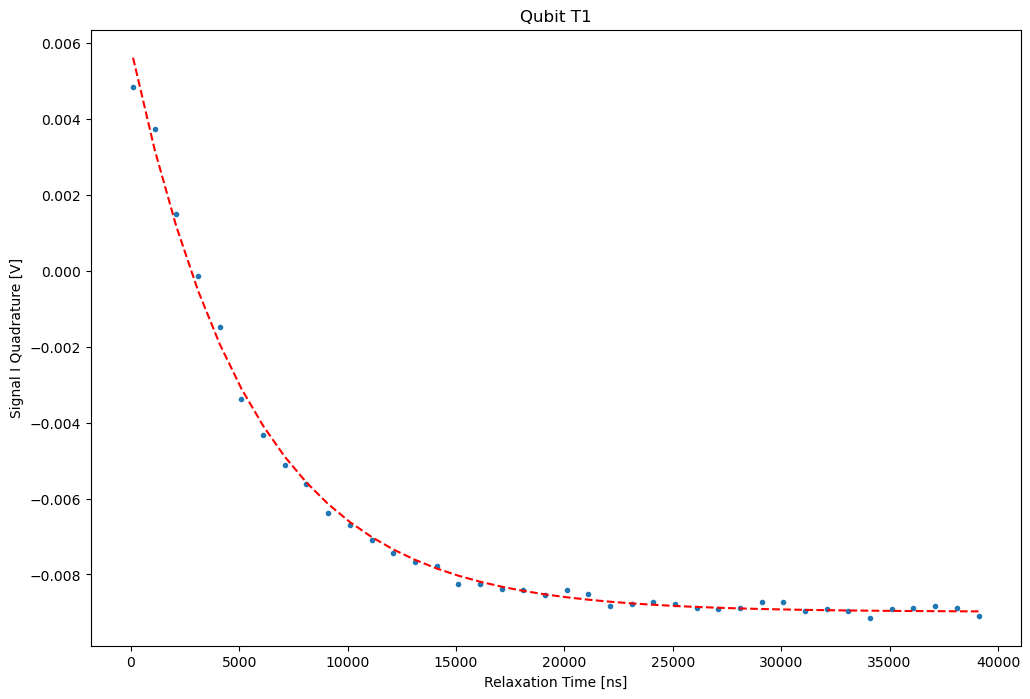

In [58]:
%matplotlib inline
qubit_T1 = Analysis.exp1D.T1(expt_dataset, data_process_method = 'I')
machine.qubits[qubit_index].T1 = qubit_T1 + 0E6
machine = Analysis.set_machine(machine)

## Qubit Ramsey

In [103]:
%matplotlib qt
ramsey_duration_sweep = np.arange(16, 10000 + 0.1, 52)  # in units of ns
machine, expt_dataset = Experiment.exp1D.Ramsey.ramsey(machine, ramsey_duration_sweep, qubit_index, detuning = 2E6, live_plot = True,
                                                       n_avg = 20E3, cd_time = 30E3, to_simulate = False, data_process_method = 'I')

Execution stopped by user!                                   ] 9.1% (n=1824/20000.0) --> elapsed time: 12.31s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0924\2024-09-24_q3_ramsey848/20000.0) --> elapsed time: 12.53s


Qubit T2*:  3102.3 [ns]
Exponent n =  1.1
Detuning =  2.2 [MHz]


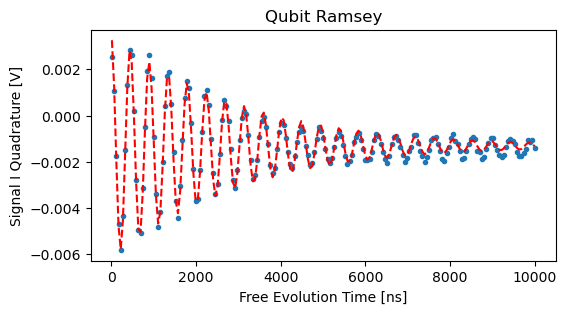

In [26]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 3]
q_T2star = Analysis.exp1D.ramsey(expt_dataset, data_process_method = 'I')
machine.qubits[qubit_index].T2 = q_T2star + 0E6
machine = Analysis.set_machine(machine)

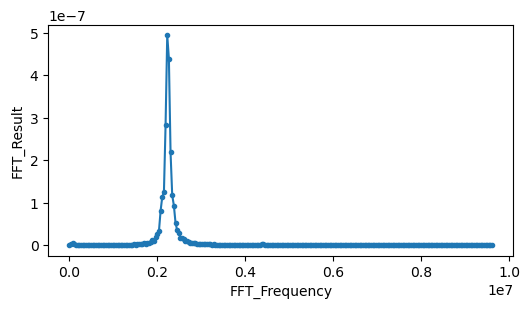

In [27]:
%matplotlib inline
fft_dataset = Analysis.exp1D.fft(expt_dataset, to_plot = True, data_process_method = 'I')

## ef transition

### ef frequency

In [169]:
%matplotlib qt
ef_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-190E6, -130E6 + 1, 0.5E6) 
machine, expt_dataset = Experiment.exp1D.Rabi.ef_freq(machine, ef_freq_sweep, qubit_index, pi_amp_rel_ef = 1.0, n_avg = 2E3, live_plot = True,
                                                      cd_time = 30E3, readout_state = 'g', to_simulate = False, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 8.13s
Execution stopped by user!
----------saved to Z:\QM_Data_DF5\2024\07\Data_0711\2024-07-11_q3_ef_spec


peak frequency:  5753.7 [MHz]


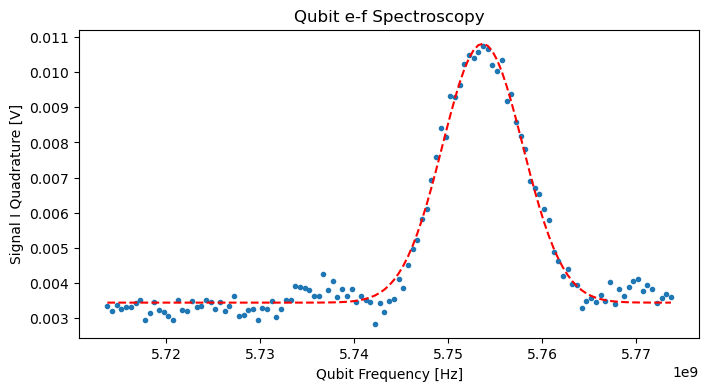

In [170]:
%matplotlib inline
ef_freq = Analysis.exp1D.peak_fit(expt_dataset, method="Gaussian", data_process_method = 'I')

In [125]:
machine.qubits[qubit_index].anharmonicity = machine.qubits[qubit_index].f_01 - ef_freq
machine = Analysis.set_machine(machine)

In [126]:
machine.qubits[qubit_index].anharmonicity

148490729.0

### ef transition time Rabi

In [135]:
%matplotlib qt
rabi_duration_sweep = np.arange(16, 240 + 0.1, 4)  # in ns
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, expt_dataset = Experiment.exp1D.Rabi.ef_rabi_length(machine, rabi_duration_sweep, qubit_index, pi_amp_rel_ef = 1.0, live_plot = True,
                                                                             n_avg = 2E3, cd_time = 30E3, readout_state = 'g', 
                                                                             to_simulate = False, simulation_len = 10_000, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 3.53s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0628\2024-06-28_q3_time_rabi_ef_2


rabi_pi_pulse: 79.3 [ns]
pi period: 76.26 [ns]


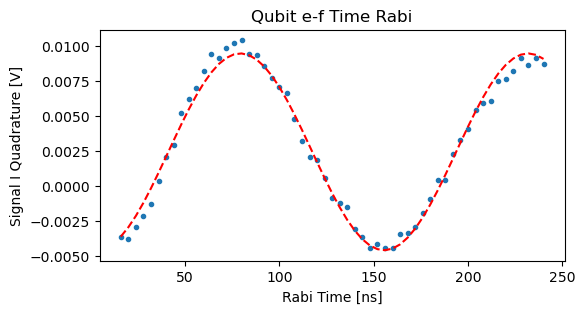

In [137]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(expt_dataset, data_process_method = 'I')

In [138]:
machine.qubits[qubit_index].pi_length_ef = 180
machine = Analysis.set_machine(machine)

### ef transition power Rabi

In [131]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.2, 2.0, 0.025) 
machine, expt_dataset = Experiment.exp1D.Rabi.ef_rabi_amp(machine, rabi_amp_sweep_rel, qubit_index, n_avg = 2E3, cd_time = 30E3, live_plot = True,
                                                          readout_state = 'g', to_simulate = False, simulation_len = 1000, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 4.90s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0628\2024-06-28_q3_power_rabi_ef


rabi_pi_amp: 0.020 [V]
pi period: 0.019 [V]


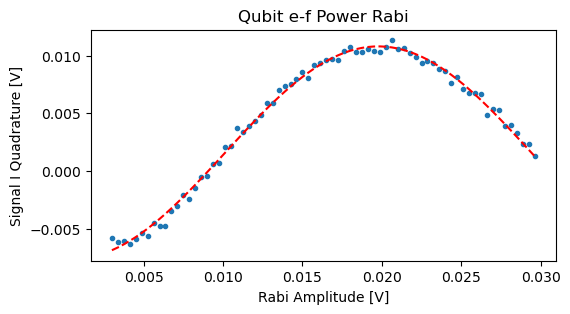

In [133]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(expt_dataset, method = "Sine", data_process_method = 'I')

In [134]:
machine.qubits[qubit_index].pi_amp_ef = pi_pulse_amp
machine = Analysis.set_machine(machine)

## Qubit DD

### Qubit Echo

In [31]:
%matplotlib qt
tau_sweep_abs = np.arange(16, 32E3 + 0.1, 20)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.qubit_echo(machine, tau_sweep_abs, qubit_index,n_avg = 10E3,
                     cd_time_qubit = 30E3, live_plot = True)

Execution stopped by user!##################                 ] 66.7% (n=6671/10000.0) --> elapsed time: 675.76s
----------saved to Z:\QM_Data_DF5\2024\08\Data_0822\2024-08-22_q3_qubit_echo_40000.0) --> elapsed time: 676.29s


Qubit T2*:  10.8 [us]
Exponent n =  1.3


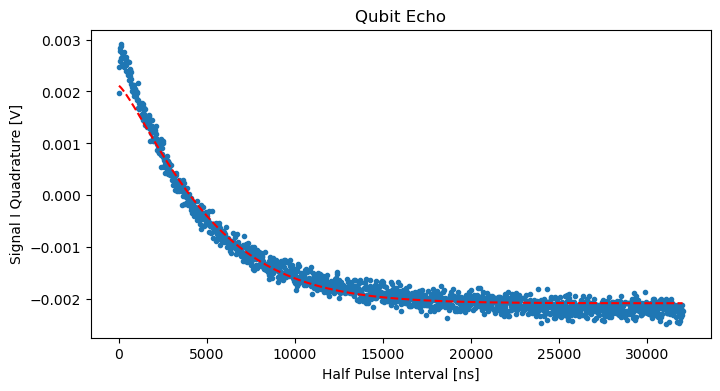

In [32]:
%matplotlib inline
Qubit_T2echo = Analysis.exp1D.T2(expt_dataset, data_process_method = 'I', N_tau =2)

### Qubit CPMG

### CPMG 2

In [9]:
%matplotlib qt
N_CPMG = 2
tau_sweep_abs = np.arange(500, 20E3 + 0.1, 0.252E3)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.qubit_CPMG(machine, tau_sweep_abs, qubit_index,  N_CPMG = N_CPMG,
                     n_avg = 10E3, cd_time_qubit = 30E3, live_plot = True)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 56.65s
----------saved to Z:\QM_Data_DF5\2024\08\Data_0822\2024-08-22_q3_qubit_cpmg2_2


Qubit T2*:  14.6 [us]
Exponent n =  1.5


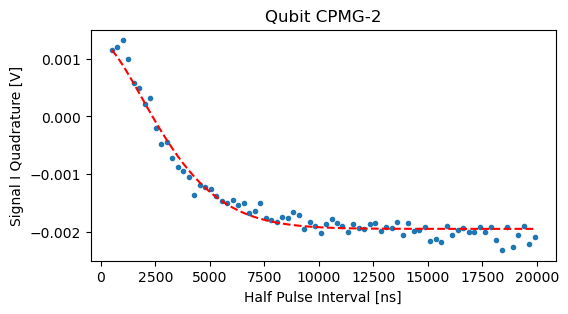

In [11]:
%matplotlib inline
Qubit_T2dd = Analysis.exp1D.T2(expt_dataset, data_process_method = 'I', N_tau = 2 * N_CPMG)

## CPMG 8

In [15]:
%matplotlib qt
N_CPMG = 8
tau_sweep_abs = np.arange(500, 7E3 + 0.1, 128)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.qubit_CPMG(machine, tau_sweep_abs, qubit_index,  N_CPMG = N_CPMG,
                     n_avg = 20E3, cd_time_qubit = 30E3, live_plot = True)

Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 93.13s
----------saved to Z:\QM_Data_DF5\2024\08\Data_0822\2024-08-22_q3_qubit_cpmg8_4


Qubit T2*:  28.5 [us]
Exponent n =  1.8


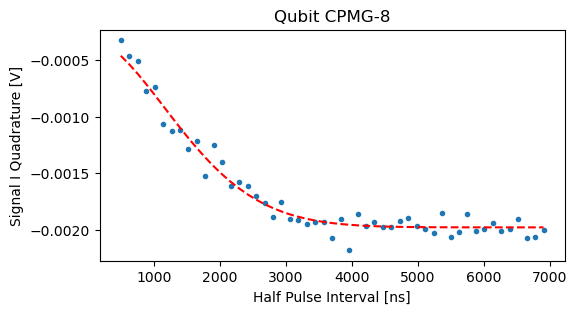

In [17]:
%matplotlib inline
Qubit_T2dd = Analysis.exp1D.T2(expt_dataset, data_process_method = 'I', N_tau = 2 * N_CPMG)

### CPMG 16

In [21]:
%matplotlib qt
N_CPMG = 16
tau_sweep_abs = np.arange(16, 3.5E3 + 0.1, 20)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.qubit_CPMG(machine, tau_sweep_abs, qubit_index,  N_CPMG = N_CPMG,
                     n_avg = 20E3, cd_time_qubit = 30E3, live_plot = True)

Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 311.41s
----------saved to Z:\QM_Data_DF5\2024\08\Data_0822\2024-08-22_q3_qubit_cpmg16_4
Execution stopped by user!


Qubit T2*:  10.6 [us]
Exponent n =  1.1


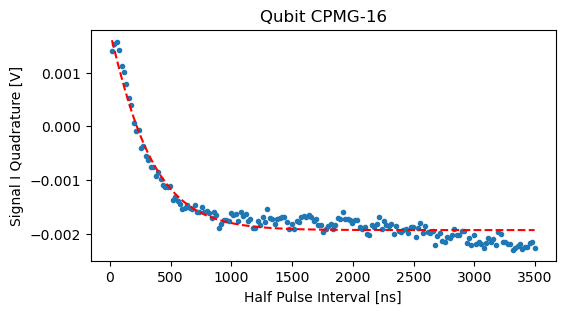

In [23]:
%matplotlib inline
N_CPMG=16
Qubit_T2dd = Analysis.exp1D.T2(expt_dataset, data_process_method = 'I', N_tau = 2 * N_CPMG)

# Qubit Tuning Curves

## 2D qubit spectroscopy vs dc flux

In [68]:
# try the experiment
%matplotlib qt
dc_flux_sweep = machine.dc_flux[dc_flux_index].max_frequency_point + np.arange(-0.5,0.5+1E-4,0.05)
qubit_if_sweep = np.arange(-30E6, 30E6, 1E6)
machine, expt_dataset = Experiment.exp2D.Rabi.qubit_freq_vs_dc_flux(machine, dc_flux_sweep, qubit_if_sweep, qubit_index,
                                 n_avg = 500, cd_time = 30E3, final_plot = True, live_plot = False ,  data_process_method = 'Amplitude')

Progress: [##################################################] 100.0% (n=21/21) --> elapsed time: 180.94s
----------saved to Z:\QM_Data_DF5\2024\08\Data_0822\2024-08-22_q3_res_spec_vs_dc_flux_3
----------saved to Z:\QM_Data_DF5\2024\08\Data_0822\2024-08-22_q3_qubit_spec_vs_dc_flux_3


In [54]:
expt_data = xr.load_dataset(r"Z:\QM_Data_DF5\2024\05\Data_0517\2024-05-17_q1_qubit_spec_vs_dc_flux_9.nc")

In [69]:
# udpate the sweet spot
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_flux(expt_dataset, fit_order = 2, to_plot = False ,  data_process_method = 'Amplitude')
machine.dc_flux[dc_flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param) + 0E1
print(f"sweet spot flux: {machine.dc_flux[dc_flux_index].max_frequency_point:.5f} V")

sweet spot flux: 0.39071 V


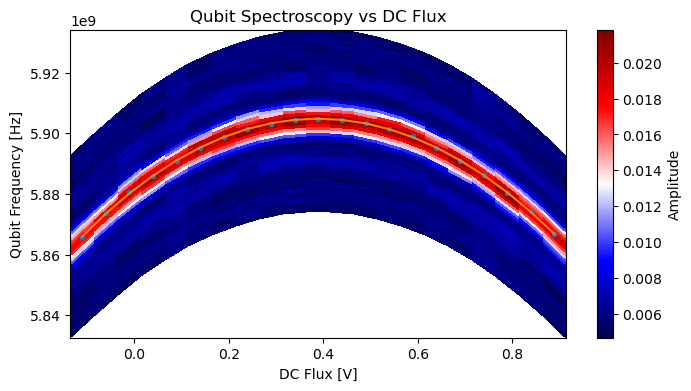

In [71]:
# save the sweep spot flux according to fitted parameter
poly_param = Analysis.exp2D.qubit_vs_flux(expt_dataset, fit_order = 4, to_plot = True,  data_process_method = 'Amplitude')
machine.qubits[qubit_index].DC_tuning_curve = poly_param
machine = Analysis.set_machine(machine)

In [72]:
# go to the sweet spot, if needed
machine.dc_flux[dc_flux_index].dc_voltage = machine.dc_flux[dc_flux_index].max_frequency_point
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
machine = Analysis.set_machine(machine)

## 2D qubit spectroscopy vs fast flux

In [73]:
# set DC voltage to sweet spot, after possible dc flux sweep
machine.dc_flux[dc_flux_index].dc_voltage = machine.dc_flux[dc_flux_index].max_frequency_point
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
machine = Analysis.set_machine(machine)

### slow version, compiling 1D scans

In [74]:
# try the experiment
%matplotlib qt
#ff_sweep = np.arange(-0.02,-0.28-1E-4,-0.02)
ff_sweep = np.arange(0,0.2+1E-4,0.03)
qubit_if_sweep = np.arange(-50E6, 50E6 + 1, 1E6)
machine, expt_dataset = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(machine, ff_sweep,qubit_if_sweep,
      qubit_index, ff_to_dc_ratio = None, n_avg = 1E3, cd_time = 25E3)

Progress: [##################################################] 100.0% (n=7/7) --> elapsed time: 36.89s
----------saved to Z:\QM_Data_DF5\2024\08\Data_0822\2024-08-22_q3_qubit_spec_vs_fast_flux


In [3]:
expt_dataset = xr.load_dataset(r"Z:\QM_Data_DF5\2024\06\Data_0610\2024-06-10_q3_qubit_spec_vs_fast_flux.nc")

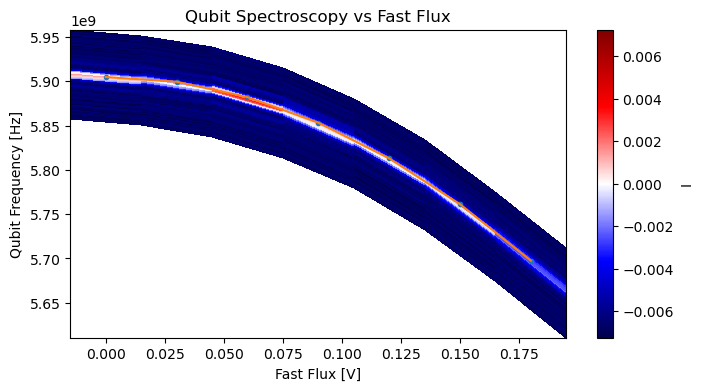

In [76]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_flux(expt_dataset, fit_order = 4, to_plot = True, data_process_method = 'I', fit_type = 'peak')
machine.qubits[qubit_index].AC_tuning_curve = poly_param
machine = Analysis.set_machine(machine)

### fast version, runs blockwise 2D sweeps

In [133]:
%matplotlib qt
q_freq_max = np.floor(np.polyval(machine.qubits[qubit_index].AC_tuning_curve, 0.0) * 1E6)
qubit_freq_sweep = np.arange(q_freq_max, 4.7E9, -100E6)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 0.5E6)

# qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 0.5E6)
machine, expt_dataset = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux(machine, qubit_freq_sweep,qubit_if_sweep,
          qubit_index, n_avg = 1, cd_time = 25E3, final_plot = True, live_plot = True)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q3 for (LO, IF) = (5.600 GHz,  200.000 MHz)
------------------------------------- Octave calibration finished.
Progress: [##################################################] 100.0% (n=1/1) --> elapsed time: 0.03s
Progress: [##################################################] 100.0% (n=1/1) --> elapsed time: 0.04s
------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q3 for (LO, IF) = (5.400 GHz,  200.000 MHz)
------------------------------------- Octave calibration finished.
Progress: [##################################################] 100.0% (n=1/1) --> elapsed time: 0.03s
Progress: [##################################################] 100.0% (n=1/1) --> elapsed time: 0.04s
------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q3 for (LO, IF) = (4.8

In [54]:
%matplotlib qt
expt_data = xr.load_dataset(r"Z:\QM_Data_DF5\2024\08\Data_0822\2024-08-22_q3_qubit_spec_vs_fast_flux_3.nc")
expt_data['I'].plot(x = "Fast_Flux", y = "Qubit_Frequency", cmap="seismic")


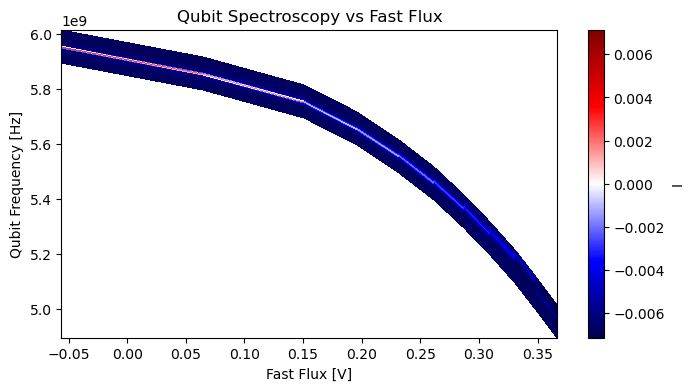

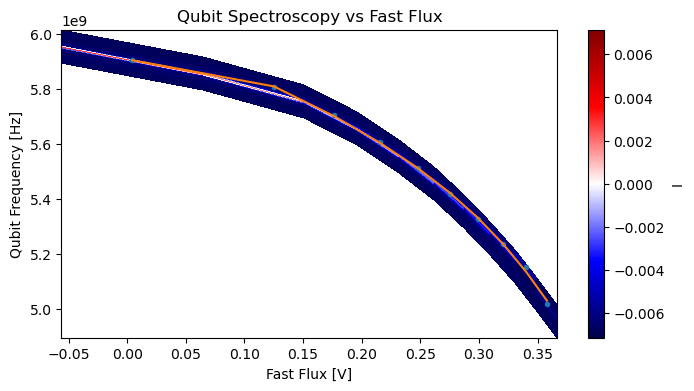

Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!


In [78]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_flux(expt_dataset, fit_order = 4, to_plot = True, data_process_method = 'I', fit_type = 'peak')
machine.qubits[qubit_index].AC_tuning_curve = poly_param
machine = Analysis.set_machine(machine)

# TLS experiments

## TLS SWAP spectroscopy

In [131]:
# Go back to the sweet spot and calibrate
machine.qubits[qubit_index].f_01 = int(np.floor(np.polyval(machine.qubits[qubit_index].AC_tuning_curve, 0.0) * 1E6)) + 0E6
machine.octaves[0].LO_sources[1].LO_frequency = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)

In [132]:
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q3 for (LO, IF) = (5.950 GHz, -50.000 MHz)
------------------------------------- Calibrates r3 for (LO, IF) = (6.930 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


### coarse, no baking

In [68]:
%matplotlib qt
tau_sweep_abs = np.arange(16,100 + 0.1,4)
ff_sweep_abs = np.arange(0.1,0.45,0.002)
machine, expt_dataset = Experiment.exp2D.SWAP.swap_coarse(machine, tau_sweep_abs, ff_sweep_abs, qubit_index, 
                      n_avg = 1E3, cd_time = 25E3, live_plot=True)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 196.98s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 197.55s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0610\2024-06-10_q3_swap2D


In [72]:
data = xr.load_dataset(r"Z:\QM_Data_DF5\2024\06\Data_0610\2024-06-10_q3_swap2D.nc")
data['Amplitude'].plot(x = "Fast_Flux", y = "Interaction_Time", cmap="seismic")


### fine, with baking

In [233]:
%matplotlib qt
tau_sweep_abs = np.arange(4,200,2)
ff_sweep_abs = np.arange(0.1,0.45+1E-4,0.001)
machine, expt_dataset = Experiment.exp2D.SWAP.swap(machine, tau_sweep_abs, ff_sweep_abs, qubit_index,
                      n_avg = 5E3, cd_time = 30E3, live_plot=True)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 13679.55s
----------saved to Z:\QM_Data_DF5\2024\07\Data_0717\2024-07-17_q3_swap2D_3
Execution stopped by user!


In [244]:
expt_dataset = xr.load_dataset(r"Z:\QM_Data_DF5\2024\07\Data_0717\2024-07-17_q3_swap2D_3.nc")
expt_dataset['I'].plot(x = list(expt_dataset.coords.keys())[0], y = list(expt_dataset.coords.keys())[1], cmap = "seismic", vmin = -0.001, vmax = 0.008)

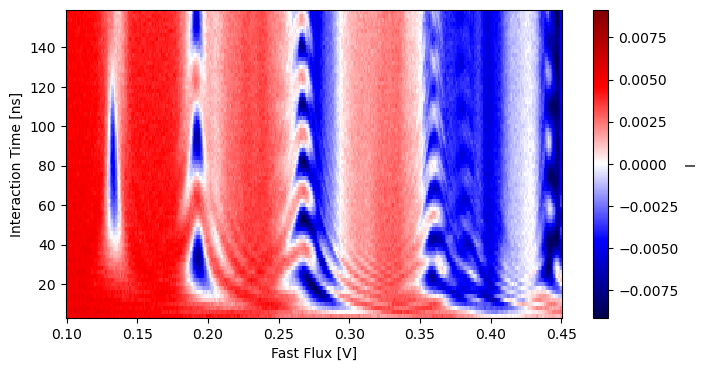

In [149]:
%matplotlib inline
expt_dataset = xr.load_dataset(r"Z:\QM_Data_DF5\2024\06\Data_0629\2024-06-29_q3_swap2D.nc")
expt_dataset['I'].plot(x = list(expt_dataset.coords.keys())[0], y = list(expt_dataset.coords.keys())[1], cmap = "seismic")

In [109]:
fft_dataset = Analysis.exp2D.SWAP_fft(expt_dataset, to_plot = True)

### Add TLS iswap params

In [91]:
expt_dataset = xr.load_dataset(r"Z:\QM_Data_DF5\2024\05\Data_0519\2024-05-19_q1_swap2D_2.nc")

SWAP plot, to find the SWAP param range for different TLS

In [30]:
%matplotlib qt
expt_dataset['Amplitude'].plot(x = list(expt_dataset.coords.keys())[0], y = list(expt_dataset.coords.keys())[1], cmap = "seismic")
plt.show()

initialize the iswap params in quam

In [7]:
machine.flux_lines[qubit_index].iswap.length =[]
machine.flux_lines[qubit_index].iswap.level = []

#### TLS0

In [110]:
flux_min, flux_max = (0.18,0.21)
interaction_time_min, interaction_time_max = (10,50)
flux_range = (flux_min, flux_max)
interaction_time_range = (interaction_time_min, interaction_time_max)

iswap flux level:  0.19200 [V]
iswap flux length:  32 [ns]


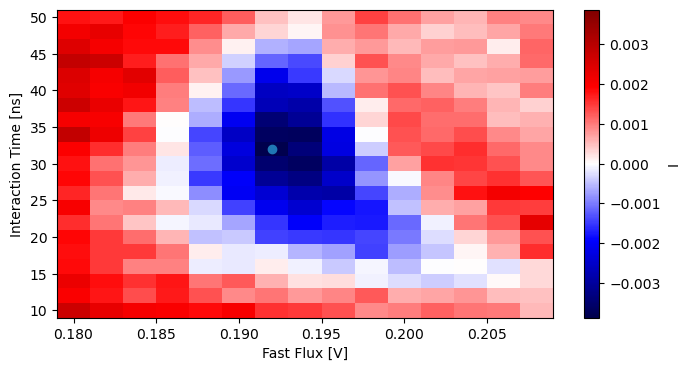

In [112]:
%matplotlib inline
iswap_flux, iswap_time = Analysis.exp2D.SWAP_find_iswap(expt_dataset, flux_range, interaction_time_range, to_plot = True)

In [119]:
machine.flux_lines[qubit_index].iswap.level

[0.192, 0.274, 0.374]

In [120]:
machine.flux_lines[qubit_index].iswap.length

[32, 18, 20]

In [113]:
machine.flux_lines[qubit_index].iswap.length[0] = iswap_time
machine.flux_lines[qubit_index].iswap.level[0] = iswap_flux
machine = Analysis.set_machine(machine)

In [16]:
machine.flux_lines[qubit_index].iswap.length.append(iswap_time)
machine.flux_lines[qubit_index].iswap.level.append(iswap_flux)
machine = Analysis.set_machine(machine)

#### TLS1

In [116]:
flux_min, flux_max = (0.264,0.282)
interaction_time_min, interaction_time_max = (12,24)
flux_range = (flux_min, flux_max)
interaction_time_range = (interaction_time_min, interaction_time_max)

iswap flux level:  0.27400 [V]
iswap flux length:  18 [ns]


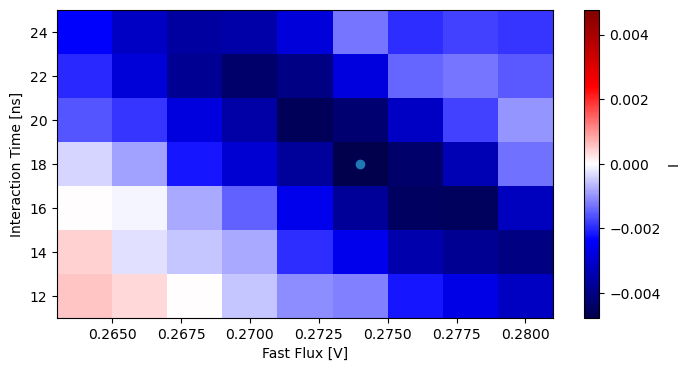

In [117]:
%matplotlib inline
iswap_flux, iswap_time = Analysis.exp2D.SWAP_find_iswap(expt_dataset, flux_range, interaction_time_range, to_plot = True)

In [118]:
machine.flux_lines[qubit_index].iswap.length[1] = iswap_time
machine.flux_lines[qubit_index].iswap.level[1] = iswap_flux
machine = Analysis.set_machine(machine)

In [22]:
machine.flux_lines[qubit_index].iswap.length.append(iswap_time)
machine.flux_lines[qubit_index].iswap.level.append(iswap_flux)
machine = Analysis.set_machine(machine)

#### TLS2

In [121]:
flux_min, flux_max = (0.278,0.286)
interaction_time_min, interaction_time_max = (22,34)
flux_range = (flux_min, flux_max)
interaction_time_range = (interaction_time_min, interaction_time_max)

iswap flux level:  0.28200 [V]
iswap flux length:  28 [ns]


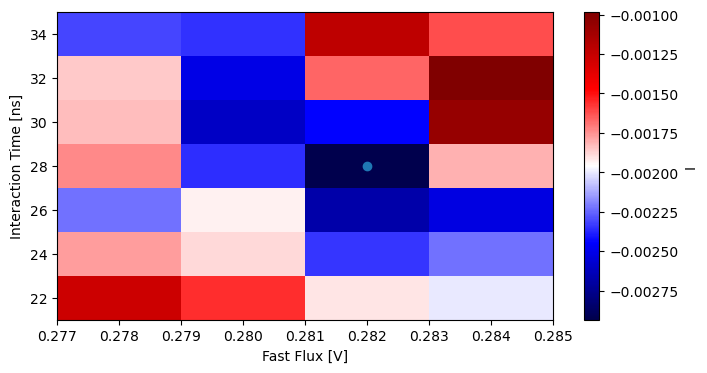

In [123]:
%matplotlib inline
iswap_flux, iswap_time = Analysis.exp2D.SWAP_find_iswap(expt_dataset, flux_range, interaction_time_range, to_plot = True)

In [124]:
machine.flux_lines[qubit_index].iswap.length[2] = iswap_time
machine.flux_lines[qubit_index].iswap.level[2] = iswap_flux
machine = Analysis.set_machine(machine)

In [31]:
machine.flux_lines[qubit_index].iswap.length.append(iswap_time)
machine.flux_lines[qubit_index].iswap.level.append(iswap_flux)
machine = Analysis.set_machine(machine)

### TLS3

In [150]:
flux_min, flux_max = (0.35,0.365)
interaction_time_min, interaction_time_max = (10,30)
flux_range = (flux_min, flux_max)
interaction_time_range = (interaction_time_min, interaction_time_max)

iswap flux level:  0.35900 [V]
iswap flux length:  24 [ns]


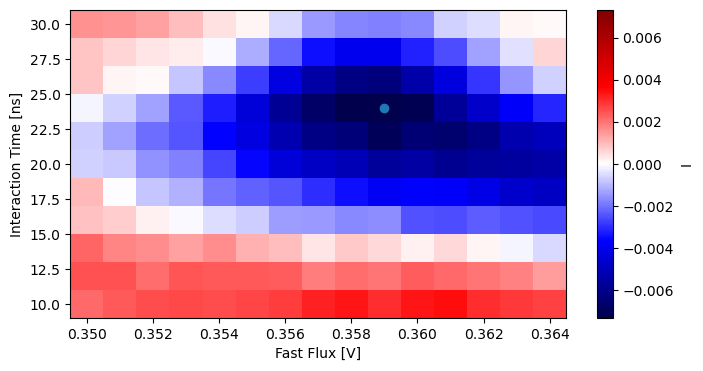

In [151]:
%matplotlib inline
iswap_flux, iswap_time = Analysis.exp2D.SWAP_find_iswap(expt_dataset, flux_range, interaction_time_range, to_plot = True)

In [153]:
machine.flux_lines[qubit_index].iswap.length[3] = iswap_time
machine.flux_lines[qubit_index].iswap.level[3] = iswap_flux
machine = Analysis.set_machine(machine)

### TLS4

In [136]:
flux_min, flux_max = (0.37,0.39)
interaction_time_min, interaction_time_max = (0,24)
flux_range = (flux_min, flux_max)
interaction_time_range = (interaction_time_min, interaction_time_max)

iswap flux level:  0.37400 [V]
iswap flux length:  16 [ns]


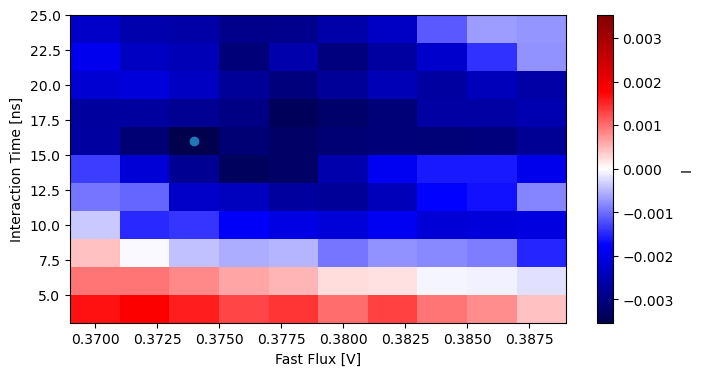

In [137]:
%matplotlib inline
iswap_flux, iswap_time = Analysis.exp2D.SWAP_find_iswap(expt_dataset, flux_range, interaction_time_range, to_plot = True)

In [138]:
machine.flux_lines[qubit_index].iswap.length[4]=iswap_time
machine.flux_lines[qubit_index].iswap.level[4]=iswap_flux
machine = Analysis.set_machine(machine)

### estiguess of the TLS frequency, based on iswap flux level

In [133]:
freq_tls = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[qubit_index].iswap.level)
machine.qubits[qubit_index].f_tls = (np.floor(freq_tls*1E6)).tolist()    
machine = Analysis.set_machine(machine)

initialize pi_length_tls, pi_amp_tls

In [135]:
machine.qubits[qubit_index].pi_length_tls = [200] * len(machine.flux_lines[qubit_index].iswap.length)
machine.qubits[qubit_index].pi_amp_tls = [0.45] * len(machine.flux_lines[qubit_index].iswap.length)
machine = Analysis.set_machine(machine)

In [139]:
freq_tls = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[qubit_index].iswap.level)

In [140]:
freq_tls

array([5663.93305623, 5411.2451049 , 5381.32639457, 5047.18168238,
       4964.81890685])